In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../pyutils')
import metrics
import utils

# Introduction

In unsupervised learing, one has a set of $N$ observations $x_i \in \mathbb{R}^p$, having joint density $P(X)$.  
The goal is to infer properties of this density.  
At very low dimension ($p \leq 3$), several methods can directly estimate $P(X)$ for any $X$. But these methods fail in high-dimensions.  

It can be used to:
- Identify low-dimensional manifolds with high data density.
- Cluster analysis finds multiple convex regions that contains modes of $P(X)$
- Mixture modeling try to estimate $P(X)$ with a mixture of density functions.
- Association rules: construct simple rules that describe regions of high density.  

In unsupervised learning, there is no measure of success, it's difficult to prove the conclusions of the model.

# Association Rules

The general goal of association rules is to find values $v_1, \text{...}, v_L$ such that the probability density $P(X=v_l)$ is relatively large. This problem is also called mode finding or bump hunting. For problems with a large number of values, the number of observations such that $X=v_l$ is usually too small to be reliable.  

One solution is to seek regions of the $X$-space. Let $s_{j}$ a subset of values taken by feature v$X_j$.  
The goal is to find $s_{1},\text{...},s_p$ such that the folowing value is large:
$$P \left( \bigcap_{j=1}^p (X_j \in s_j) \right)$$

## Market Basket Analysis

This problem is usually not feasible for $p$ and $N$ large.  

Market Basket Analysis is a special case where all predictions are binary: $X_j \in \{ 0, 1 \}$.  
The goal is to find a subset of integers $\mathcal{K} \subset \{ 1, \text{...}, p \}$ such that the following value is large:
$$P \left( \bigcap_{k \in \mathcal{K}} (X_k = 1) \right) = \prod_{k \in \mathcal{J}} P(X_k = 1)$$

$\mathcal{K}$ is called an item set. This value is called the support or prevalente $T(\mathcal{K})$. It can be estimated from the dataset:
$$T(\mathcal{K}) = \frac{1}{N} \sum_{i=1}^N \prod_{k \in \mathcal{K}} x_{ik}$$  

The goal of the algorithm is to fing, given a lower bound $t$ for the support, all item sets with support greater than $t$:
$$\{ \mathcal{K}_l | T(\mathcal{K}_l) > t \}$$

There are $2^J$ possible item sets, fortunately they are algorithms that allow to find the item sets without looking at all the possibilities.

## The Apriori Algorithm

This algorithm can handle very large $N$ and $p$ as long as the number of itemset with support greather than $t$ is small enough.  
It uses the following property:
$$\mathcal{L} \subseteq \mathcal{K} \implies T(\mathcal{L}) \geq T(\mathcal{K})$$

It works by doing only a few passes through the training set.  
The first pass over the data compute the support of all single-item sets, and discards all with support lower than $t$.  
The following passes combine the remaining itemsets with the ones remaining after the first pass, and discard all with support lower than $t$.  
The process stops when all itemsets are discarded.  

Each obtained itemset $\mathcal{K}$ into two subsets such that: $A \cup B = \mathcal{K}$, written $A \implies B$.  

The support of the rule is written $T(A \implies B) \approx P(A \cap B)$, it is the same as $T(\mathcal{K})$.  
The support is the proportion of observations having $A \cap B$.

The confidence is the proportion of obversations having $B$ among all those having $A$. It is written $C(A \implies B)$.
$$C(A \implies B) = \frac{T(A \implies B)}{T(A)} \approx P(B|A)$$

The lift is how likely it is to have $A$ and $B$ relative to $B$. It is written $L(A \implies B)$.
$$L(A \implies B) = \frac{C(A \implies B)}{T(B)} \approx \frac{P(B|A)}{P(B)}$$

## Example

Given a dataset of 7500 transactions from a french retail store, find associative rules from it

Dataset: [Link](https://drive.google.com/file/d/1y5DYn0dGoSbC22xowBq2d4po6h1JxcTQ/view)

In [2]:
import os
from apyori import apriori
from google_drive_downloader import GoogleDriveDownloader as gdd

FILE_ID ='1y5DYn0dGoSbC22xowBq2d4po6h1JxcTQ'
FILE_PATH = '/tmp/store_data.csv'

if not os.path.isfile(FILE_PATH):
    gdd.download_file_from_google_drive(file_id=FILE_ID,
                                       dest_path=FILE_PATH)


data = pd.read_csv(FILE_PATH, header=None)
data.head()

records = []
for i in range(data.shape[0]):
    records.append([str(data.values[i,j]) for j in range(data.shape[1]) if str(data.values[i,j]) != 'nan'])

In [3]:
rules = apriori(records, min_support=0.0235, 
                min_confidence=0.1, 
                min_lift=1.5, min_length=2)  

res = list(rules)
print(len(res))

11


In [4]:
for item in res:
    s = ''
    stats = item.ordered_statistics[0]
    for x in stats.items_base:
        s += str(x) + '; '
    s += '=> '
    for x in stats.items_add:
        s += str(x) + '; '
    s += ('S = {:.4f}, C = {:.4f}, L = {:.4f}'.format(item.support,
                                         stats.confidence,
                                         stats.lift))
    print(s)

burgers; => eggs; S = 0.0288, C = 0.3303, L = 1.8378
chocolate; => milk; S = 0.0321, C = 0.1961, L = 1.5133
frozen vegetables; => milk; S = 0.0236, C = 0.2476, L = 1.9104
frozen vegetables; => mineral water; S = 0.0357, C = 0.3748, L = 1.5725
frozen vegetables; => spaghetti; S = 0.0279, C = 0.2923, L = 1.6789
ground beef; => mineral water; S = 0.0409, C = 0.4166, L = 1.7475
ground beef; => spaghetti; S = 0.0392, C = 0.3989, L = 2.2912
milk; => mineral water; S = 0.0480, C = 0.3704, L = 1.5538
milk; => spaghetti; S = 0.0355, C = 0.2737, L = 1.5718
mineral water; => olive oil; S = 0.0276, C = 0.1158, L = 1.7579
pancakes; => spaghetti; S = 0.0252, C = 0.2651, L = 1.5225


In [5]:

class AprioriRule:
    
    def __init__(self, a, b, support, confidence, lift):
        self.a = a
        self.b = b
        self.support = support
        self.confidence = confidence
        self.lift = lift


class Apriori:
    
    
    def __init__(self, min_support, min_confidence,
                min_lift, min_length):
        self.min_support = min_support
        self.min_confidence = min_confidence
        self.min_lift = min_lift
        self.min_length = min_length
        
    def fit(self, data):
        
        #1) build dict of words
        self.lwords = []
        self.dwords = dict()
        for entry in data:
            for w in entry:
                if not w in self.dwords:
                    self.dwords[w] = len(self.lwords)
                    self.lwords.append(w)
             
        #2) build data matrix
        self.X = np.zeros((len(data), len(self.lwords)))
        for i in range(len(data)):
            for w in data[i]:
                self.X[i, self.dwords[w]] = 1
                

    
        #3) first pass through dataset
        rules = []
        res = []
        for j in range(self.X.shape[1]):
            items = [j]
            s = self.get_support(items)
            if s >= self.min_support:
                res.append(items)
                rules.append(items)
        
        res1 = list(res)
        
        
        # 4) other passes through dataset until no itemset found
        while len(res) > 0:
            
            res_next = []
            for items in res:
                for other in res1:
                    if other[0] > items[-1]:
                        items_ext = items + other
                        s = self.get_support(items_ext)
                        if s >= self.min_support:
                            res_next.append(items_ext)
                            rules.append(items_ext)
                            
            res = res_next
        
        # 5) remove lists too short
        rules = [x for x in rules if len(x) >= self.min_length]
    
        # 6) divide rules into A => B rules
        rules_ex = []
        for r in rules:
            rules_ex += self.split_rule(r)
        rules = rules_ex
        
        # 7) compute all rules stats
        rules = [self.build_rule(r) for r in rules]
        
        # 8) filter rules
        rules = [r for r in rules if r.confidence > self.min_confidence
                and r.lift > self.min_lift]

        self.rules = rules
    
    
    def get_support(self, items):
        n = 0
        for x in  self.X:
            val = 1
            for it in items:
                if x[it] == 0:
                    val = 0
                    break
            n += val
        
        return n / len(self.X)
        
    def split_rule(self, r):
        res = []
        for i in range(len(r) - 1):
            p1 = r[:i+1]
            p2 = r[i+1:]
            res.append((p1, p2))
        return res
        
    def build_rule(self, r):
        sab = self.get_support(r[0] + r[1])
        sa = self.get_support(r[0])
        sb = self.get_support(r[1])
        support = sab
        confidence = support / sa
        lift = confidence / sb
        
        wa = [self.lwords[x] for x in r[0]]
        wb = [self.lwords[x] for x in r[1]]
        return AprioriRule(wa, wb, support, confidence, lift)
        
mod = Apriori(min_support=0.0235, 
                min_confidence=0.1, 
                min_lift=1.5, min_length=2)

mod.fit(records)

print(len(mod.rules))

11


In [6]:
for item in mod.rules:
    s = ''
    for x in item.a:
        s += str(x) + '; '
    s += '=> '
    for x in item.b:
        s += str(x) + '; '
    s += ('S = {:.4f}, C = {:.4f}, L = {:.4f}'.format(item.support,
                                         item.confidence,
                                         item.lift))
    print(s)

mineral water; => olive oil; S = 0.0276, C = 0.1158, L = 1.7579
mineral water; => milk; S = 0.0480, C = 0.2013, L = 1.5538
mineral water; => frozen vegetables; S = 0.0357, C = 0.1499, L = 1.5725
mineral water; => ground beef; S = 0.0409, C = 0.1717, L = 1.7475
burgers; => eggs; S = 0.0288, C = 0.3303, L = 1.8378
milk; => frozen vegetables; S = 0.0236, C = 0.1821, L = 1.9104
milk; => spaghetti; S = 0.0355, C = 0.2737, L = 1.5718
milk; => chocolate; S = 0.0321, C = 0.2479, L = 1.5133
frozen vegetables; => spaghetti; S = 0.0279, C = 0.2923, L = 1.6789
spaghetti; => pancakes; S = 0.0252, C = 0.1447, L = 1.5225
spaghetti; => ground beef; S = 0.0392, C = 0.2251, L = 2.2912


## Unsupervised as Supersived learning

We are trying to estimate the probability density $g(x)$.  
We onyl have access to a reference probability density $g_0(x)$. It could be for example the uniform density over the range of the variables.  We can easily sample $N_0$ observations from $g_0(x)$.  
We also have the dataset $x_1,\text{...},x_N$, an i.i.d. random sample drawn from $g(x)$.  

Let's pool this two datasets together and assign mass $w = \frac{N_0}{N+N_0}$ to those drawn from $g(x)$, and $w_0 = \frac{N}{N+N_0}$ to those drawn from $g_0(x)$. We get a mixture density $\frac{g(x) + g_0(x)}{2}$.  

If we assign $Y=1$ to sample draw from $g(x)$ and $Y=0$ to those draw from $g_0(x)$, we get:
$$\mu(x) = E(Y|x) = \frac{g(x)}{g(x) + g_0(x)}$$  

$\mu_x$ can be estimated by supervised learning by combining the $N$ samples from $g(x)$ with $Y=1$, and the $N_0$ samples from $g_0(x)$ with $Y=0$.  
Then, we can get an estimate for $g(x)$:
$$\hat{g}(x) = g_0(x) \frac{\hat{\mu}(x)}{1 - \hat{\mu}(x)}$$  

The accuracy of $\hat{g}(x)$ greatly depends on the choice of $g_0(x)$.

## Generalized Association rules

The goal is to find a subset of integers $\mathcal{J} \subset \{ 1, 2, \text{...}, p \}$ and the corresponding value subjects $s_j$ so that the following value is large:
$$P \left( \bigcap_{j \in \mathcal{J}} (X_j \in s_j) \right)$$ 
This can be estimated by:
$$\frac{1}{N} \sum_{i=1}^N I \left( \bigcap_{j \in \mathcal{J}} (x_{ij} \in s_j) \right)$$  

This favors the discovery of itemsets whose marginal constituents $(X_j \in s_j)$ are frequent, that is the following value is large:
$$\frac{1}{N} \sum_{i=1}^N I(x_{ij} \in s_j)$$  

A good reference distribution is the product of the marginal distributions:

$$g_0(x) = \prod_{j=1}^J g_j(x_j)$$

A sample from $g_0(x)$ is easily generated from the original dataset by appliying different random permutation to the data values of each of the variables.

After drawing samples from $g_0(x)$, we get a training dataset for supervised learning, with $Y \in \{ 0, 1 \}$.  
The goal is to use this data to find regrions:
$$R = \bigcap{j \in \mathcal{J}} (X_j \in s_j)$$

for which $\mu(x) = E(Y|x)$ is large.  
One might also require that the support os these regions is big enough:
$$T(R) = \int_{x \in R} g(x)dx$$  

Decision trees are such a model, each leaf $t$ represent a region $R$:
$$\bar{y}_t = \text{ave}(y_i|x_i \in t)$$
The actual data support is given by:
$$T(R) = \bar{y}_t \frac{N_t}{N + N_0}$$
with $R_t$ the number of observations in the leaf $t$.

In [7]:
from sklearn.tree import DecisionTreeRegressor

class GeneralizedAssosRules:
    
    
    def __init__(self, t):
        self.t = t
        
    def fit(self, X):
        N, p = X.shape
        N0 = 2*N
        
        X0 = X[np.random.choice(N, size=N0, replace=True)]
        for j in range(p):
            X0[:, j] = X0[np.random.permutation(N0), j]
        
        Xe = np.vstack((X, X0))
        ye = np.vstack((np.ones((N, 1)), np.zeros((N0, 1))))
        
        self.tree = DecisionTreeRegressor()
        self.tree.fit(Xe, ye)
        
        
        print(Xe.shape)
        print(ye.shape)
        
        
X = np.random.randn(124, 7)
mod = GeneralizedAssosRules(0.2)

mod.fit(X)

(372, 7)
(372, 1)


# Cluster Analysis

It consists of grouping a collection of obects into subsets (called clusters) such that those within each cluster are more closely related to one another than objects from other clusters.  
To form clusters, an important notion is the degree of similarity or dissimmalirity between two objects.  
It can be a distance, like the euclidian distance. It is used for example by K-Means clustering which use a top-down procedure to build clusters.  
Other approches are mostly bottom-up.

## Proximity Matrices

$Let D \in \mathbb{R}^{N*N}$ the matrix of dissimilarities, with $N$ the number of objects.  
$D_{ij}$ represents the proximity between object $i$ and object $j$. Usually it's symmetric matrix with nonnegative entries, and zeroes on the diagonal.  

We usually have $x_ij$ with $N$ observations and $p$ features. We need to compute the dissimilarity between 2 observations in order to build $D$. One solution is to use a dissimilarity $d_j(x_{ij}, x_{i'j})$ for each feature:
$$D(x_i, x_{i'}) = \sum_{j=1}^p d_j(x_{ij}, x_{i'j})$$

For quantitative variables, we define an error: $d(x_i, x_{i'}) = l(|x_i - x_{i'}|)$. Usually it's the squared error loss, or the absolute error.  
Or in cal also be based on correlation:
$$p(x_i, x_{i'}) = \frac{\sum_j (x_{ij} - \bar{x}_i)(x_{i'j} - \bar{x}_{i'})}{\sqrt{\sum_j (x_{ij} - \bar{x}_i)^2 \sum_j (x_{i'j} - \bar{x}_{i'})^2}}$$

with $\bar{x}_i = \sum_{j} x_{ij}/p$.  

For ordinal variables, we usually replace their $M$ original values by:
$$\frac{i - 1/2}{M}$$
with $i$ the original order of the variable.  
Then they are treated as quantitative variables.  

For categorical variables, the dissemilarity must be defined explicitly, by using a $M*M$ matrix for examples.  

They are several ways to combine all $d_j(x_{ij}, x_{i'j})$. It can be with a weighted average:
$$D(x_i, x_{i'}) = \sum_{j=1}^p w_j d_j(x_{ij}, x_{i'j})$$
$$\text{with } \sum_{j=1}^p w_j = 1$$

Setting $w_j = 1/j$ does not give all attribute equal influence. To get equal influence, you should set $w_j = 1/\bar{d}_j$ with:
$$\bar{d}_j = \frac{1}{N^2} \sum_{i=1}^N \sum_{i'=1}^N d_j(x_{ij}, x_{i'j})$$  
This seems a reasonable idea, but may be counterproductive. To cluser data, you may not want all attributes to contribute equally.

## Clustering Algorithms

The goal of clustering os to partition data into groups so that the dissimilarities between those assigned to the same cluster are smaller than those in different clusters.  
They fall into three types:
- combinatorial algorithms
- mixture modelling
- mode seeking

## Combinatorial algorithms

These algorithms assign each observation to a cluster without any probability model. Each observation $x_i$ is assigned to a cluster $k \in \{1, \text{...}, K \}$.  
These assignments can be characterized by an encoder: $k = C(i)$.  
The models looks for $C^*(i)$ that achieves a particular goal. It is adjusted to minimize a loss function that charactherize the clustering goal.  

One possible loss is the within-cluster point scatter. It make observations in the same cluster as close as possible:
$$W(C) = \frac{1}{2} \sum_{k=1}^K \sum_{C(i)=k} \sum_{C(i')=k} d(x_i, x_{i'})$$

Another loss is the between-cluster point scatter. It makes observations in different cluster as far as possible:
$$B(C) = \frac{1}{2} \sum_{k=1}^K \sum_{C(i)=k} \sum_{C(i')\neq k} d(x_i, x_{i'})$$

Minimize $W(C)$ is equivalent to maximize $B(C)$.  
Th total point scatter $T$ is a constant given the data, independant of cluster assignment.
$$T = W(C) + B(C)$$  

Minimize this loss function by testing all assignments is intractable. For only $N=19$ and $K=4$, they are around $10^{10}$ possible assignments.  
Algorithms are often based on iterative greedy descent. It starts with initial assignments, that are changed in each step, in a way to reduce the loss function. The algorithm terminates when there is no possible improvment. But the result is a local optima, which may be highly suboptimal compared to the global optimum.

## K-Means

K-Means is a combinatorial algorithm that uses the squared Euclidian distance:
$$d(x_i, x_{i'}) = ||x_i - x_{i'}||^2$$

We are minimizing the within-cluster distance:
$$W(C) = \sum_{k=1}^K N_k \sum_{C(i) = k} ||x_i - \bar{x}_k||^2$$
with $\bar{x}_k$ the mean of all observations in cluster $k$, and $N_k$ the number of observations in cluster $K$

We are trying to solve:
$$C^* = \min_C  \sum_{k=1}^K N_k \sum_{C(i) = k} ||x_i - \bar{x}_k||^2$$

The K-Means algorithm is reaally simple:
1. Initialize the $R$ clusters randomly (from training set)
2. Repeat until convergence:
    - Assign each training point to the closest centroid
    - The center of each cluster becomes the mean of all its assigned points
    
Each step reduce the loss function, but it converges only to a local mininum.  
One should start the algorithm with many different random inititialization, and choose the one with the lowest loss.

(150, 2)
(150,)
loss: 4613.551120505142


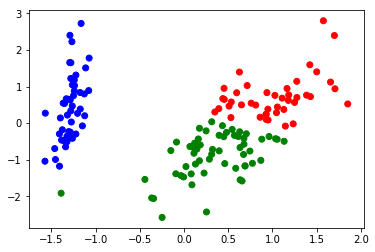

In [8]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA


class KMeansClustering:
    
    def __init__(self, R, nstarts = 100):
        self.R = R
        self.nstarts = nstarts
        
    def fit(self, X):
        
        best_loss = float('inf')
        best_means = None
        
        for _ in range(self.nstarts):
            self.train(X)
            loss = self.get_loss(X)
            if loss < best_loss:
                best_loss = loss
                best_means = self.means
                
        self.means = best_means
        
    
    def train(self, X):
    
        N, p = X.shape      
        self.means = X[np.random.choice(N, self.R)]
        
        while True:
            old_means = self.means.copy()
            
            #assign each point to the closest cluster
            ctrs = [list() for _ in range(self.R)]
            for x in X:
                ctrs[self.get_closest_ctr_idx(x)].append(x)
                
            
            # compute the new center position of every cluster
            for i in range(self.R):
                if len(ctrs[i]) != 0:
                    self.means[i] = np.mean(np.vstack(ctrs[i]), axis=0)
            
            
            if np.linalg.norm(old_means - self.means) < 1e-6:
                break
        
    def get_loss(self, X):
        
        #assign each point to the closest cluster
        ctrs = [list() for _ in range(self.R)]
        for x in X:
            ctrs[self.get_closest_ctr_idx(x)].append(x)
        
        #compute distance between each point and the cluster center
        loss = 0
        for k in range(self.R):
            for x in ctrs[k]:
                loss += len(ctrs[k])*(x-self.means[k]) @ (x-self.means[k])
        return loss
        
    
    def get_closest_ctr_idx(self, x):
        min_idx = None
        min_dist = float('inf')
        for i in range(self.R):
            dist = (x - self.means[i]) @ (x - self.means[i])
            if dist < min_dist:
                min_idx = i
                min_dist = dist

        return min_idx
    
    def predict(self, X):
        y = np.empty(len(X)).astype(np.int)
        for i in range(len(X)):
            y[i] = self.get_closest_ctr_idx(X[i])
        return y
                
        
X, y = load_iris().data, load_iris().target
X = X[np.random.permutation(len(X))]
pca = PCA(n_components=2)
X = pca.fit_transform(X)
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)
print(X.shape)
print(y.shape)
mod = KMeansClustering(3)
mod.fit(X)
colors = [ ['red', 'blue', 'green'][x] for x in mod.predict(X)]
print('loss:', mod.get_loss(X))

plt.scatter(X[:,0], X[:,1], c=colors)
plt.show()

## Gaussian Mixtures as Soft K-Means

K-Means is closely related to estimating a Gaussian mixture with the EM algorithm.  
- The E-step assign weight to each data point based on it's relative density under each mixture component (closeness)
- The M-step recompute the component density based on current weights (mean / covariance)

If every Gaussian have covariance matrix $\sigma^2 I$, the relative density under each mixture is a monote function of the euclidian distance between the data point and the mixture center. Hence EM as a soft K-Means, making probabalistic (rather than deterministic) assigment of points to cluster centers.  
As $\sigma^2 \to 0$, the probabilities become $0$ and $1$, and the two methods coincide.

## Vector Quantization

Vector Quantization is a compression technique in image / signal processing, using K-Means.  

The prodecure is:
- Break the image into small blocks, for example for a $1024*1024$ image break into $2*2$ blocks, we get $512*512$ vectors in $\mathbb{R}^4$

- A K-Means is run on the blocks. As $K$ increases, the quality of the image and the compressed size decrease.  Each block is approximated by it's closest centroid.

- We just need to store the $K$ centroids vectors, and the index of the closest centroid of all the blocks.

- To reconstruct the image, each block become it's closest centroid, and the blocks are converted to an image  

This works because with typical images many blocks look the same. It only require only one block each to represent them.  
We can go further by applying a hierarchical K-Means, or using a variable coding length.

1206.3606425940793
4790.491728413692


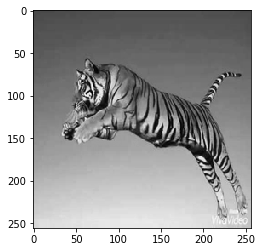

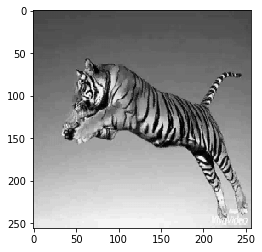

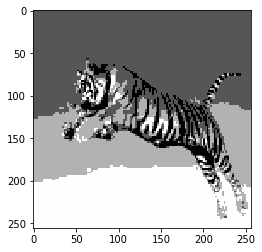

In [9]:
from PIL import Image
from sklearn.cluster import KMeans

class VectorQuantization:
    
    
    def __init__(self, K, bsize = 4):
        self.K = K
        self.bsize = 2
        
    def img2block(self, X):
        s = X.shape[0]
        res = np.empty((s//self.bsize, s//self.bsize,
                       self.bsize*self.bsize)).astype(np.int)
        
        for i in range(res.shape[0]):
            for j in range(res.shape[1]):
                res[i, j] = np.array([
                    X[2*i,2*j],X[2*i+1,2*j],X[2*i,2*j+1],X[2*i+1,2*j+1]
                ])
                
        return res.reshape(-1, self.bsize*self.bsize)
                
    def block2img(self, b):
        s2 = int(np.sqrt(b.shape[0]))
        b = b.reshape(s2, s2, self.bsize*self.bsize)
        
        X = np.empty((s2*self.bsize, s2*self.bsize)).astype(np.int)
        for i in range(s2):
            for j in range(s2):
                X[2*i,2*j] = b[i,j,0]
                X[2*i+1,2*j] = b[i,j,1]
                X[2*i,2*j+1] = b[i,j,2]
                X[2*i+1,2*j+1] = b[i,j,3]
        
        return X
        
        
    def encode(self, img):
        b = self.img2block(img)
        
        clf = KMeans(n_clusters=self.K, n_init=1)
        clf.fit(b)
        
        code = clf.labels_
        centers = clf.cluster_centers_
        return code, centers
    
    def decode(self, code, centers):
        b = np.empty((len(code), self.bsize*self.bsize)).astype(np.int)
        for i in range(len(b)):
            b[i] = centers[code[i]]
            
        return self.block2img(b)
    
IMG_URL = 'https://i.ytimg.com/vi/J4Q86j9HOao/hqdefault.jpg'
IMG_PATH = '/tmp/img.jpg'
utils.dl_file(IMG_URL, IMG_PATH)
X = Image.open(IMG_PATH)
X = X.resize((256,256), Image.ANTIALIAS)
X = X.convert('L')
X = np.asarray(X.getdata(),dtype=np.int).reshape((X.size[1],X.size[0]))

vq200 = VectorQuantization(K=200)
code, centers = vq200.encode(X)
X2 = vq200.decode(code, centers)

vq4 = VectorQuantization(K=4)
code, centers = vq4.encode(X)
X3 = vq4.decode(code, centers)

print(metrics.tdist(X, X2))
print(metrics.tdist(X, X3))

plt.imshow(X, cmap='gray')
plt.show()
plt.imshow(X2, cmap='gray')    
plt.show()
plt.imshow(X3, cmap='gray')    
plt.show()

## K-medoids

K-Means is appropriate when the dissimilairty measure $D(x_i, x_{i'})$ is the euclidian distance. These requires all variables to be of quantitative type, it the procedure lacks robustness on outliers.  
The algorithm can be generalized to any $D(x_i, x_{i'})$  We don't need the inputs $x$, only the distances.  
It's far more expensive to compute than K-Means.

K-medoids algorithm:
1. Start with a particular intialization $C(i)$
2. Repeat until the cluster assignments $C(i)$ doesn't change:
    - For each cluster $k$, find the cluster center $m_k$:
        $$m_k = \arg \min_{ \{i:C(i)=k \} } \sum_{C(i')=k} D(x_i, x_{i'})$$
        
    - Minitmize the total error by assigning each observation to the closest cluster:
        $$C(i) = \arg \min_k D(x_i, m_k)$$
        

(150, 2)
(150,)


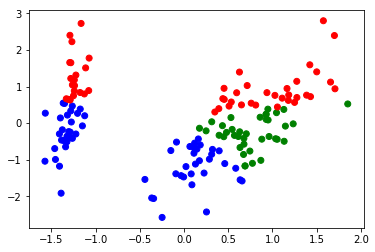

In [10]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

class KMedoidsClustering:
    
    
    def __init__(self, K):
        self.K = K
        
    def fit(self, X):
        N, p = X.shape
        self.centers = [None] * self.K
        
        # build distance matrix
        D = np.empty((N, N))
        for i in range(N):
            for j in range(N):
                D[i,j] = (X[i] - X[j]) @ (X[i] - X[j])
        X = None #X is useless, we only need D
        
        # initialization
        #assign each point ro a random cluster
        ctrs = [list() for _ in range(self.K)]
        for i in range(N):
            ctrs[np.random.randint(0, self.K)].append(i)
            
        
        while True:
            
            #estimate cluster centers
            for k in range(self.K):
                best_i = None
                best_dist = float('inf')
                ck = ctrs[k]
                for i in ck:
                    dist = 0
                    for i2 in ck:
                        dist += D[i, i2]
                    if dist < best_dist:
                        best_dist = dist
                        best_i = i
                
                self.centers[k] = best_i
                
            ##
            old_ctrs = ctrs
            ctrs = [list() for _ in range(self.K)]
            
            # assign each point to the closest cluster center
            for i in range(N):
                best_k = None
                best_dist = float('inf')
                for k in range(self.K):
                    dist = D[i, self.centers[k]]
                    if dist < best_dist:
                        best_dist = dist
                        best_k = k
                ctrs[best_k].append(i)
            
            
            #stop only if the assigments didn't changed
            changed = False
            for k in range(self.K):
                if ctrs[k] != old_ctrs[k]:
                    changed = True
                    break
            if not changed:
                break
                
            
        #build labels vectors
        self.labels = np.empty(N).astype(np.int)
        for k in range(self.K):
            for i in ctrs[k]:
                self.labels[i] = k
            
            
            
        
    
X, y = load_iris().data, load_iris().target
X = X[np.random.permutation(len(X))]
pca = PCA(n_components=2)
X = pca.fit_transform(X)
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)
print(X.shape)
print(y.shape)
mod = KMedoidsClustering(3)
mod.fit(X)
colors = [ ['red', 'blue', 'green'][x] for x in mod.labels]

plt.scatter(X[:,0], X[:,1], c=colors)
plt.show()

## Initialization

It can be defined by specifying an initial set of centers $\{ m_1, \text{...}, m_K$ or an initial encoder $C(i)$. Specifying the center is usually more convenient.  
A strategy based of forward stepwise assignment is derived, called K-Means++.  

K-Means++ agorithm:  

1. Initialize the first center $m_1$ uniformly at random from all observations.
2. For $k=2 \to K$:

    - Compute for every observation the distance with the closest of the already chosen centroids:
        $$D(i) = \min_{c = \{ m_1, \text{...}, m_{k-1} \} } D(x_i, c)$$
        
    - Choose the center $m_k$ from a weighted probability probability distribution of $X$, with weights $D(i)^2$ 

(150, 2)
(150,)
loss: 4613.551120505142


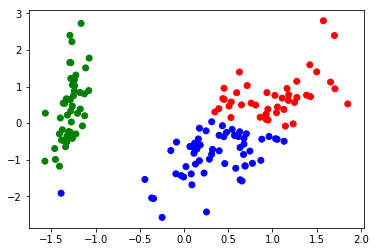

In [11]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA


class KMeansClustering:
    
    def __init__(self, R, nstarts = 100):
        self.R = R
        self.nstarts = nstarts
        
    def fit(self, X):
        
        best_loss = float('inf')
        best_means = None
        
        for _ in range(self.nstarts):
            self.train(X)
            loss = self.get_loss(X)
            if loss < best_loss:
                best_loss = loss
                best_means = self.means
                
        self.means = best_means
        
    
    def train(self, X):
    
        N, p = X.shape
        
        # K-means++ Initialization
        self.means = np.empty((self.R, p))
        self.means[0] = X[np.random.choice(N)]
        
        for k in range(1, self.R):
            d = np.empty(N)
            for i in range(N):
                d[i] = min([(X[i]-self.means[c])@(X[i]-self.means[c])
                             for c in range(k)])
            d /= np.sum(d)
            self.means[k] = X[np.random.choice(N, p=d)]
                          
        
        while True:
            old_means = self.means.copy()
            
            #assign each point to the closest cluster
            ctrs = [list() for _ in range(self.R)]
            for x in X:
                ctrs[self.get_closest_ctr_idx(x)].append(x)
                
            
            # compute the new center position of every cluster
            for i in range(self.R):
                if len(ctrs[i]) != 0:
                    self.means[i] = np.mean(np.vstack(ctrs[i]), axis=0)
            
            
            if np.linalg.norm(old_means - self.means) < 1e-6:
                break
        
    def get_loss(self, X):
        
        #assign each point to the closest cluster
        ctrs = [list() for _ in range(self.R)]
        for x in X:
            ctrs[self.get_closest_ctr_idx(x)].append(x)
        
        #compute distance between each point and the cluster center
        loss = 0
        for k in range(self.R):
            for x in ctrs[k]:
                loss += len(ctrs[k])*(x-self.means[k]) @ (x-self.means[k])
        return loss
        
    
    def get_closest_ctr_idx(self, x):
        min_idx = None
        min_dist = float('inf')
        for i in range(self.R):
            dist = (x - self.means[i]) @ (x - self.means[i])
            if dist < min_dist:
                min_idx = i
                min_dist = dist

        return min_idx
    
    def predict(self, X):
        y = np.empty(len(X)).astype(np.int)
        for i in range(len(X)):
            y[i] = self.get_closest_ctr_idx(X[i])
        return y
                
        
X, y = load_iris().data, load_iris().target
X = X[np.random.permutation(len(X))]
pca = PCA(n_components=2)
X = pca.fit_transform(X)
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)
print(X.shape)
print(y.shape)
mod = KMeansClustering(3)
mod.fit(X)
colors = [ ['red', 'blue', 'green'][x] for x in mod.predict(X)]
print('loss:', mod.get_loss(X))

plt.scatter(X[:,0], X[:,1], c=colors)
plt.show()

## Choice of K

One technique is to use a loss function, such as the within-cluster dissimilarity $W_K$, and compute it for several values of K. But this loss is decreasing with the number of $K$, even when used on a validation set with Cross-Validation.  

The value of $K$ start decreasing exponentially, then at a point the difference between each $K$ abruptly decrease.  
Heuristically, set $K^*=K$ for this particular $K$ when the difference become less important, gives good results.  
The $K^*$ can be found simply by plotting $W_K$ for different values of $K$. The plot looks like an elbow at $K^*$. This method is also called the elbow method.

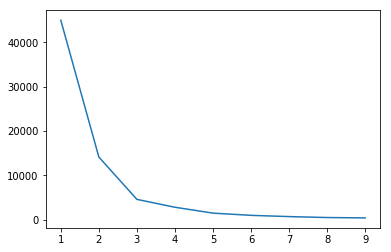

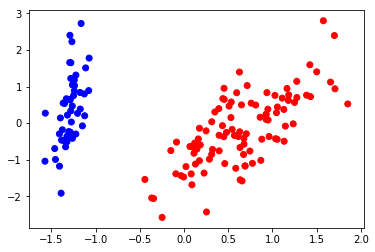

In [12]:
losses = []
for k in range(1, 10):
    mod = KMeansClustering(k)
    mod.fit(X)
    losses.append(mod.get_loss(X))
    
plt.plot(np.arange(1, 10), losses)
plt.show()

best_k  = 2 #by looking at plot

mod = KMeansClustering(best_k)
mod.fit(X)
colors = [ ['red', 'blue', 'green'][x] for x in mod.predict(X)]
plt.scatter(X[:,0], X[:,1], c=colors)
plt.show()

## Hierarchical Clustering

Hierarchical clustering uses only a measure of dissimilarity between 2 groups of observations.  
They produce hierarchical representations in wich the clusters at each level are created by merging clusters at the next lower level. At the lowest level there is $N$ clusters of size $1$, and at the highest $1$ cluster of size $N$.  

There exist two-strategies:
- Aglomerative (bottom-up): Start at the bottom and and recursively merge a pair of clusters into one
- Divisive (top-down): Start at the top and recursively split one cluster into two.  

Each level represents a different grouping of the data. It's up to the user to decide which level represents a natural clustering.  
Most methods posseses a monotonicity property: The dissimilarity between clusters is monotone increasing with the level.  

The model can be plotted as a binary tree, where the height of each node is proportional to the value of the intergroup dissimilarity between it's two children. This is called a dendogram.  
The results are valid only if the data really posseses a hierarchical structure.

## Agglomerative Clustering

It starts with every observation in a different cluster.  
At each step, the closest 2 clusters are merged.  
After $N-1$ steps, the algorithm stops with only one cluster left.  
A measure of dissimilary between 2 groups, $d(G,H)$ is needed. They are several possibilities:

- Single Linkage is the least dissimilar of all pairs:
$$d_\text{SL}(G,H) = \min_{i \in G, i' \in H} d_{ii'}$$

- Complete Linkage is the most dissimilar of all pairs:
$$d_\text{CL}(G,H) = \max_{i \in G, i' \in H} d_{ii'}$$

- Group Average is the mean dissimilairty between all pairs:
$$d_\text{GA}(G,H) = \frac{1}{N_G N_H} \sum_{i \in G} \sum_{i' \in H} d_{ii'}$$

If the data is compact (small dissimilarities between clusters, clusters well separated from each others), all methods produce similar results.  

Single Linkage only requires a single pair of two groups to be small to combine them. It has a tendency to combine at relatively low thresholds, observations linked by a series of close intermediates. This phenomem, called chaining, is a defect of the method.  

Complete Linkage is the other extreme, two groups are similar if all their obrservations are close. It tends to produce compact clusters, however it may produce clusters with observations much closer to members of other clusters than to member of their own cluster, breaking the closoness property.  

Groupe average is a compromise between the two.

## Divisive Clustering

It begins with the whole dataset into one cluster, then recursively divide one existing cluster in two.  
Ater $N-1$ steps, are $N$ clusters of size $1$.  
This approach is less used than agglomerative clustering.  

Place all observations in a single cluster $G$.  
Chooses the observations whose average dissimilairy from all other observations is the largest. It is the first member of a new cluster H.  
At each step, the observation in $G$ whose average dissimilarity from those in H, minus the remaining observations in G, is transfered to H.  
It continues until the largest value became negative. The original cluster is then split in two, G and H.  
At each step a new cluster is chosen an split in two. The cluster chosen can be the one with the largest diameter, or the largest average dissimilarity between it's members.

# Self-Organizing Maps

Self-organization of a massive document collection - Kohonen, T., Kaski, S., Lagus, K., Saloj ̈arvi, J., Paatero,A. and Saarela,A. (2000) - [PDF](http://lig-membres.imag.fr/bisson/cours/M2INFO-AIW-ML/papers/Kohonen00.pdf)

This method can be viewed as a constrained version of K-Means, where the prototype are encouraged to lie in a or two dimensional manifold in the feature space.  
We consider a SOM as a rectangular grid of $q_1*q_2=K$ prototypes $m_j \in \mathbb{R}^p$.  
Once the model is fit, the observations can be mapped into the rectangular grid.  

Algorithm:
For each observation $x$_i:
- Find the cluster $m_j$ closest to $x_i$
- Find all clusters $m_k$ such that the distance in the grid between $l_j$ and $l_k$ is lower than $r$.
- Move all $m_k$ closer to $x_i$:
$$m_k \leftarrow m_k + \alpha (x_i - m_k)$$

Thousands of iterations are made over the dataset. At each iteration, $\alpha$ and $r$ are decreased.  
The update both move the prototypes closer to the data, but also maintain a smooth 2D spatial relationship between prototypes.

iteration: 0
iteration: 50
iteration: 100
iteration: 150
iteration: 200
recons error: 4.41780419397064


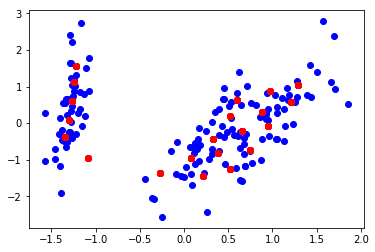

In [13]:
def d2_dist(a, b):
    return (a[0]-b[0])**2 + (a[1]-b[1])**2

class SOM:
    
    def __init__(self, Q, niters = 1000):
        self.Q = Q
        self.niters = niters
        
        self.alpha_beg = 1
        self.alpha_end = 0
        self.dalpha = (self.alpha_end - self.alpha_beg) / self.niters
        
        self.r_beg = 10
        self.r_end = 1
        self.dr = (self.r_end - self.r_beg) / self.niters
        
    def get_closest_centroid(self, x):
        best_dist = float('inf')
        best_pos = None
        
        for i in range(self.Q):
            for j in range(self.Q):
                dist = (self.clusters[i,j]-x) @ (self.clusters[i,j]-x)
                if dist < best_dist:
                    best_dist = dist
                    best_pos = (i,j)
        
        return best_pos

    
    def fit(self, X):
        N, p = X.shape
        
        self.clusters = np.random.randn(self.Q, self.Q, p)
        alpha = self.alpha_beg
        r = self.r_beg
        
        for it in range(self.niters):
            
            for x in X:
            
                i0, j0 = self.get_closest_centroid(x)
                
                for i in range(self.Q):
                    for j in range(self.Q):
                        if d2_dist((i,j), (i0,j0)) < r:
                            d = x - self.clusters[i,j]
                            self.clusters[i,j] += alpha * d
            
            if it % 50 == 0:
                print('iteration:', it)
            
            alpha += self.dalpha
            r += self.dr
        
    def reconstruct(self, X):
        X2 = np.empty(X.shape)
        for i in range(len(X)):
            pos = self.get_closest_centroid(X[i])
            X2[i] = self.clusters[pos]
        return X2
        
        
X, y = load_iris().data, load_iris().target
X = X[np.random.permutation(len(X))]
pca = PCA(n_components=2)
X = pca.fit_transform(X)
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)
mod = SOM(Q=5, niters=250)
mod.fit(X)
Xr = mod.reconstruct(X)

print('recons error:', np.linalg.norm(X - Xr))
plt.scatter(X[:,0], X[:,1], c='blue')
plt.scatter(Xr[:,0], Xr[:,1], c='red')
plt.show()

# Principal Components, Curves and Surfaces

Principal Components provides a sequence of best linear approximations of the data, of all ranks $q \leq p$.  
The parametric representation of an affine hyperplane is:
$$f(\lambda) = \mu + V_q \lambda$$
with $\mu \in \mathbb{R}^p$ a location vector, $V_q \in \mathbb{R}^{p*q}$ a matrix with unit orthogonal columns vectors, and $\lambda \in \mathbb{R}^q$ a vector of parameters.  

We can fit this model by minimizing the reconstruction error:
$$\min_{\mu, \lambda_i, V_q} \sum_{i=1}^N ||x_i - \mu - V_q\lambda_i||^2$$
When we partially optimize of $\mu$ and $\lambda_i$ we get:
$$\hat{\mu} = \bar{x}$$
$$\hat{\lambda}_i = V^T_q(x_i - \bar{x})$$

The problem becomes:
$$\min_{V_q} ||(x_i - \bar{x}) - V_qV^T_q(x_i - \bar{x})||^2$$

We assume $\bar{x} = 0$. The reconstruction matrix $H_q \in \mathbb{R}^{p*p}$ is a projection matrix such that $H_q = V_qV_q^T$  

The solution can be found with the singular value decomposition of $X$ centered:
$$X = UDV^T$$

For each rank $q$, the solution $V_q$ are the first $q$ columns of V.

In [14]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

class MyPCA:
    
    def __init__(self, q):
        self.q = q
        
    def fit(self, X):
        Xc = np.mean(X, axis=0, keepdims=True)
        X = X - Xc
        
        U, d, VT = np.linalg.svd(X)
        Vq = VT[:self.q].T
        
        self.Xc = Xc
        self.Vq = Vq
        
        
    def transform(self, X):
        return (X - self.Xc) @ self.Vq 
    
    def inverse_transform(self, Xq):
        return (Xq @ self.Vq.T) + self.Xc
    
        
X, y = load_iris().data, load_iris().target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=15)


p1 = MyPCA(q=2)
p1.fit(X_train)
p2 = PCA(n_components=2)
p2.fit(X_train)

Xtrq1 = p1.transform(X_train)
Xtrq2 = p2.transform(X_train)
print(Xtrq1.shape)
print(metrics.tdist(Xtrq1, Xtrq2))

Xteq1 = p1.transform(X_test)
Xteq2 = p2.transform(X_test)
print(Xteq1.shape)
print(metrics.tdist(Xteq1, Xteq2))

Xtrr1 = p1.inverse_transform(Xtrq1)
Xtrr2 = p2.inverse_transform(Xtrq2)
print(Xtrr1.shape)
print(metrics.tdist(Xtrr1, Xtrr2))

Xter1 = p1.inverse_transform(Xteq1)
Xter2 = p2.inverse_transform(Xteq2)
print(Xter1.shape)
print(metrics.tdist(Xter1, Xter2))

(120, 2)
6.633321496558339e-15
(30, 2)
3.045051981330325e-15
(120, 4)
1.050730930714469e-14
(30, 4)
5.0193869307412495e-15


The colums of $UD$ are called the principal components.  the $N$ optimal $\hat{\lambda}_i$ are given by the first q principal components.

## Principal Curves and Surfaces

Principal curve generelize the principal component line. It provides a smooth one-dimensional curved approximation of a set of data points.  
A principal surface is more general, provides a curved manifold approximation of dimension 2 or more.

## Spectral Clustering

Traditional clustering methods use spherical or elliptical metrics, and won't work well if the clusters are non-convex. Spectral clustering is a generalization designed for these situations.  

Let's define a matrix of similarities $S \in \mathbb{R}^{N*N}$, with $s_{ii'} \geq 0$ the similarity between $x_i$ and $x_{i'}$.  
Let $G = <V, E>$ an undirected similarity graph with vertices $v_i$ for each observation, and edges weighted by $s_{ii'}$ only if reaches a specific threshold, otherwhise there is no edge.  

Clustering is now a graph problem, we wish to partition the graph such that edges between different groups have low weight, and within a group have high weight.  

Let $d_{ii'}$ the euclidian distance between $x_i$ and $x_{ii'}$. One similarity mesure is the radial-kernel gram matrix: $s_{ii'} = \exp (-d^2_{ii'}/c)$, with $c > 0$ a scale parameter.  

One way to define a similarity graph is the mutual K-nearest neighbor graph. Define $\mathcal{N}_k$ the symmetric set of nearby pair of points. A pair $(i,i')$ if $x_i$ is among the K-nearest neighbors of $x_{i'}$, or vice versa.  
We connect all pairs in $\mathcal{N}_k$ with weight $w_{ii'} = s_{ii'}$, otherwhise the weight is 0.  
Another way is to include all edges to get a fully connected graph, with weights $w_{ii'}=s_{ii'}$.  

The matrix of edge weights $W \in \mathbb{R}^{N*N}$ is called the adjency matrix.  
The degree of vertex $i$ is $g_i = \sum_{i'} w_{ii'}$. Let $G \in \mathbb{R}^{N*N}$ a diagonal matrix with diagonal elements $g_i$.  
The graph Laplacian is defined by $L = G - W$.  

Spectral clustering find the $m$ eigenvectors corresponding to the $m$ smallest eigenvalues of $L$. It gives us the matrix $Z \in \mathbb{R}^{N*m}$.  
Using a standard method like K-Means, we cluster the rows of $Z$ to yield a clustering of the original points.

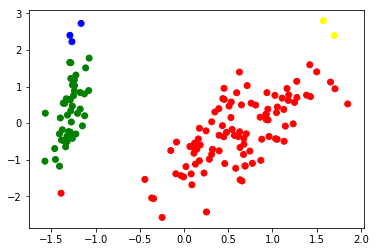

In [15]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

class SpectralClustering:
    
    def __init__(self, K, c, m):
        self.K = K
        self.c = c
        self.m = m
        
    def fit(self, X):
        N, p = X.shape
        
        S = np.array([
            [np.exp(-(X[i]-X[j])@(X[i]-X[j])/self.c) for i in range(N)]
            for j in range(N)
        ])
        
        W = S
        G = np.diag(np.sum(W, axis=0))
        L = G - W
        
        w, V = np.linalg.eigh(L)
        Z = V[:, 1:self.m+1]
        
        km = KMeansClustering(self.K)
        km.fit(Z)
        
        self.Z = Z
        self.km = km
        self.labels = km.predict(Z)
        


X, y = load_iris().data, load_iris().target
X = X[np.random.permutation(len(X))]
pca = PCA(n_components=2)
X = pca.fit_transform(X)
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)
mod = SpectralClustering(K=4, c=1, m=2)
mod.fit(X)
colors = [ ['red', 'blue', 'green', 'yellow'][x] for x in mod.labels]

plt.scatter(X[:,0], X[:,1], c=colors)
plt.show()

## Kernel Principal Components

Kernel principal component analysis - Bernhard Schoelkopf, Alexander J. Smola, and Klaus-Robert Mueller. (1999) - [PDF](http://pca.narod.ru/scholkopf_kernel.pdf)

In PCA, we diagonalize an estimate an estimate of the covariance matrix:
$$C = \frac{1}{p} \sum_{j=1}^p x_{:,j} x_{:,j}^T$$

Kernel PCA follows the same principle, but first map non lineary the data into another feature space using the transformation $\Phi$. As for kernel SVM methods, be don't need to compute $\Phi(x)$, only the dot product $\Phi(x_i)^T\Phi(x_j)$

The covariance matrix became:

$$\bar{C} = \frac{1}{p} \sum_{j=1}^p \Phi(x_{:,j}) \Phi(x_{:,j})^T$$  
We need to find engeinvalues $\lambda$ and eigenvectors $V$ satisfying $\lambda V = \bar{C} V$.

Let's define the kernel matrix $K \in \mathbb{R}^{N*N}$ such that:
$$K_{ij} = \Phi(x_i)^T \Phi(x_j)$$

We now solve the eigenvalue problems:
$$\lambda \alpha = K \alpha$$

We get the projected data on $q$ components with:
$$Z_q = \alpha * \sqrt{\lambda}$$

The kernel matrix is computed with data not centered. We need to center it first, using the following trick:
$$K_\text{center} = K - 1_NK - K1_N + 1_N K 1_N = (I - 1_N)K(I-1_N)$$

with $1_n \in \mathbb{R}^{N*N}$ a matrix with all elements equal to $1/N$.

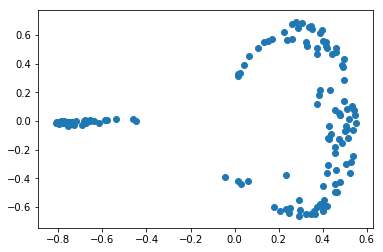

(2,) (150, 2)
[42.01600494 20.42725842]
[[-0.80611225 -0.00852789]
 [-0.75359042 -0.01212954]
 [-0.76292849 -0.00498405]
 [-0.73458891 -0.01106473]
 [-0.8005011  -0.00637607]
 [-0.67275656 -0.01237328]
 [-0.7596268  -0.00599223]
 [-0.81257844 -0.01357364]
 [-0.63732546 -0.00347022]
 [-0.77094789 -0.01398903]]


In [16]:
from sklearn.datasets import load_iris
from sklearn.decomposition import KernelPCA        

X, y = load_iris().data, load_iris().target
pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.5)
X = pca.fit_transform(X)

plt.scatter(X[:,0], X[:,1])
plt.show()

print(pca.lambdas_.shape, pca.alphas_.shape)
print(pca.lambdas_)
print(X[:10])

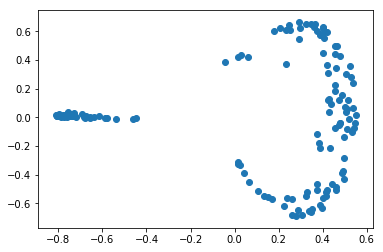

(2,) (150, 2)
[42.01600494 20.42725842]
[[-0.80611225  0.00852789]
 [-0.75359042  0.01212954]
 [-0.76292849  0.00498405]
 [-0.73458891  0.01106473]
 [-0.8005011   0.00637607]
 [-0.67275656  0.01237328]
 [-0.7596268   0.00599223]
 [-0.81257844  0.01357364]
 [-0.63732546  0.00347022]
 [-0.77094789  0.01398903]]


In [17]:
from sklearn.datasets import load_iris

from sklearn.preprocessing import KernelCenterer

def center_kernel(K):
    N = len(K)
    IM1 = np.eye(N) - (np.ones((N,N)) / N)
    return IM1 @ K @ IM1

def kernel_linear():
    return lambda a, b: a @ b

def kernel_rbf(gamma):
    return lambda x, y: np.exp(-gamma * (x - y)@(x - y))

class MyKernelPCA:
    
    def __init__(self, q, kernel):
        self.q = q
        self.kernel = kernel
        
    def fit_transform(self, X):
        N, p = X.shape        
        
        K = np.empty((N, N))
        for i in range(N):
            for j in range(N):
                K[i,j] = self.kernel(X[i], X[j])
        K = center_kernel(K)
                
        w, V = np.linalg.eigh(K)
        w, V = np.flip(w), np.flip(V, axis=1)
        wq, Vq = w[:self.q], V[:, :self.q]

        self.X = X
        self.lambdas = wq
        self.alphas = Vq
        
        return self.alphas * np.sqrt(self.lambdas)
        
        

X, y = load_iris().data, load_iris().target
pca = MyKernelPCA(q=2, kernel=kernel_rbf(0.5))
X = pca.fit_transform(X)

plt.scatter(X[:,0], X[:,1])
plt.show()

print(pca.lambdas.shape, pca.alphas.shape)
print(pca.lambdas)
print(X[:10])

## Sparse Principal Components

Sparse principal component analysis - Zou, H., Hastie, T. and Tibshirani, R. (2006) - [PDF](https://web.stanford.edu/~hastie/Papers/spc_jcgs.pdf)

Principal components can be interpret by examining the $v_j$, called loadings. The interpretiation may be easier if they are parse. Methods are usually based on a kind of Lasso (L1) penalty.  

One approach is to solve the following problem:
$$\max_v v^T(X^TX)v$$
$$\text{s.t. } \sum_{j=1}^p |v_j| \leq t, \space v^Tv=1$$  

Another strategy use the reconstruction error with some penalty. For a signe component, the criterion is:
$$\min_{\theta, v} \sum_{i=1}^N ||x_i - \theta v^T x_i||_2^2 + \lambda ||v||_2^2 + \lambda_1 ||v||_1$$
$$\text{s.t. } ||\theta||_2 = 1$$

If $\lambda=\lambda_1=0$, then $v=\theta$ is the largest principal component direction.  
The second penalty on $v$ encourages sparseness of the loadings.  

For $K$ components, the problem became:

$$\min_{\theta, v} \sum_{i=1}^N ||x_i - \Theta V^T x_i||_2^2 + \lambda \sum_{k=1}^K ||v_k||_2^2 + \sum_{k=1}^K \lambda_{1k} ||v||_1$$
$$\text{s.t. } \Theta^T\Theta= I$$

The criterion is not jointly convex in $\Theta$ and $V$, but is convex in each parameter with the other fixed.  
Minimization over $V$ is equivalent to $K$ elastic net problems.  
Minimization over $\Theta$ is solved by SVD.  
Alternation the 2 steps converges to the solution.

# Non-Negative Matrix Factorization

Learning the parts of objects by non-negative matrix factorization - Lee, D. and Seung, H. (1999) - [PDF](http://www.columbia.edu/~jwp2128/Teaching/E4903/papers/nmf_nature.pdf)  
Algorithms for non-negative matrix factorization - Lee, D. and Seung, H. (2001)- [PDF](https://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf)

Non-negative matrix factorization is an alternative approach to PCA, where  data and components are assumed to be non-negative.  
The data matrix $X$ is approximated by:
$$X \approx WH$$
with $X \in \mathbb{R}^{N*p}$, $W \in \mathbb{R}^{N*r}$, $H \in \mathbb{R}^{r*p}$, and $r \leq \max(N,p)$. We also assume that $x_{ij}, w_{ik}, h_{kj} \geq 0$.  

$W$ and $H$ are found by maximizing the log-likelihood of the data following a Poisson distribution:
$$L(W,H) = \sum_{i=1}^N \sum_{j=1}^p \left( x_{ij} \log(WH)_{ij} - (WH)_{ij} \right)$$  

By iteratively applying the following updates, we converges to a local maximum:
$$w_{ik} \leftarrow w_{ik} \frac{\sum_{j=1}^p h_{kj}x_{ij}/(WH)_{ij}}{\sum_{j=1}^p h_{kj}}$$
$$h_{kj} \leftarrow h_{kj} \frac{\sum_{i=1}^N w_{ik}x_{ij}/(WH)_{ij}}{\sum_{i=1}^N w_{ik}}$$

In [18]:
from sklearn.decomposition import NMF
from sklearn.datasets import load_iris

X, y = load_iris().data, load_iris().target
mod = NMF(3)
W = mod.fit_transform(X)
H = mod.components_

print(H)
print(metrics.tdist(W @ H, X))
print(np.sum(W>=0) == W.size)
print(np.sum(H>=0) == H.size)

[[6.45917865 1.47563158 4.51670771 0.66771724]
 [3.42634388 2.86934556 0.35195317 0.        ]
 [0.         4.92253048 7.40243384 7.18382697]]
1.9140723652638665
True
True


In [19]:
from sklearn.datasets import load_iris

class MyNMF:
    
    def __init__(self, r):
        self.r = r
        
    def fit(self, X):
        N, p = X.shape
        W = np.abs(np.random.randn(N, self.r))
        H = np.abs(np.random.randn(self.r, p))
        
        for it in range(1000):
            
            WH = W @ H
            
            for i in range(N):
                for k in range(self.r):
                    W[i,k] *= np.sum(H[k]*X[i] / WH[i]) / np.sum(H[k])
            
            WH = W @ H
            
            
            for k in range(self.r):
                for j in range(p):
                    H[k,j] *=np.sum(W[:,k]*X[:,j]/WH[:,j])/np.sum(W[:,k]) 
                    
        
        return W, H
        

            
X, y = load_iris().data, load_iris().target
mod = MyNMF(3)
W, H = mod.fit(X)

print(H)
print(metrics.tdist(W @ H, X))
print(np.sum(W>=0) == W.size)
print(np.sum(H>=0) == H.size)

[[9.11162364e-01 1.88621995e-01 1.57064676e+00 7.46003135e-01]
 [1.84031763e+00 1.48089946e+00 2.21888784e-01 1.57375484e-03]
 [2.20057220e+00 9.06710552e-01 1.22898456e+00 1.31254850e-01]]
2.34613178170397
True
True


## Archetypal Analysis

Archetypal analysis - Cutler, A. and Breiman, L. (1994) - [PDF](http://digitalassets.lib.berkeley.edu/sdtr/ucb/text/379.pdf)

This method is a propotypes method, simila to K-Means. It approximates each data point by a convex combination of a collection of prototypes.
$$X \approx WH$$
with $X \in \mathbb{R}^{N*p}$, $W \in \mathbb{R}^{N*r}$, $H \in \mathbb{R}^{r*p}$.  
We assume $w_{ik} \geq 0$ and $\sum_{k=1}^r w_{ik} = 1$. The $N$ rows of $X$ are representation by convex combinations of the $r$ archetypes (rows of H).  

The archetypes themselves are combex combinations of the obvervations:
$$H = BX$$
with $B \in \mathbb{R}^{r*N}$, $b_{ki} \geq 0$, and $\sum_{i=1}^N b_{ki}=1$.  

We minimize the following criterion:
$$J(W,B) = ||X - WBX||^2$$  

Minimizing J with respect to one variable, with the other fixed is convex for both of them.  
We iteratively minimizes $J$ with respect to $W$ then $B$ until convergence.  
But the overall problem is not convex, and it converges to a local minimum.

# Independant Component Analysis

Multivariate data are often viewed as multiple indirect measurement arising from underlying sources, that cannot be directly measured.  
Factor analysis is a classical technique to identify these latent sources. They are usually based on Gaussian distributions.  
Independant Cpomponent Analysis is another approach, that relies on the non-Gaussian nature of the underlying sources.

## Latent Variables and Factor Analysis

Let's define the reduced singular value decomposition of $X \in \mathbb{R}^{N*p}$:
$$X = UDV^T$$
Let's define $S = \sqrt{N} U$ and $A^T = DV^T / \sqrt{N}$. We get a latent variable representation:
$$X = SA^T$$
Each column of $X$ is a linar combination of the columns of $S$. The columns of $S$ have zero mean, unit variance, and are uncorrelated.

$$X_j = a_{j1}S_1 + a_{j2}S_2 + \text{...} + a_{jp}S_p$$

We can rewrite it as $X = AS$. But for any orthogonal matrix $R \in \mathbb{R}^{p*p}$ we have:
$$X = AS = AR^TRS = A^*S^*$$
with $\text{cov}(S^*) = I$. Hence they are many such decompositions, and it is therefore impossible to identify any particular latent variables as unique underlying sources.

The classic factor analysis model has the form:
$$X_j = a_{j1}S_1 + a_{j2}S_2 + \text{...} + a_{jq}S_q + \sigma_j$$
$$X = AS + \sigma$$

with $S$ a vector of $q$ underlying latent variables or factors, and $A \in \mathbb{R}^{p*q}$ a matrix of factors loadings, and $\sigma_j$ uncorrelated 0-mean disturbances.  
Typically the $S_l$ and $\sigma_j$ are modeled as Gaussians, and the model is fit by maximum ikelihood. 

## Independant Component Analysis

Let $X \in \mathbb{R}^{p*N}$, where each column of $X$ represent an observation. The goal is to find the decomposition:
$$X = AS$$
with $A \in \mathbb{R}^{p*p}$ orthogonal matrix and $S \in \mathbb{R}^{p*N}$, such that the columns of $S$ are statically independant.  
We suppose that $X$ have already been whitened ($Cov(X) = I$)  
We are trying to find an orthogonal matrix $A$ such that the components of $S=A^TX$ are indepandant (and Non-Gaussian).  

Several ICA approches are based on entropy. The diferential entropy $H$ of a random variable with density $g(Y)$ is:
$$H(Y) = - \int g(y) \log g(y) dy$$

A natural mesure of dependance is the mutual information $I(Y)$ between the components of the random vector $Y$:
$$I(Y) = \sum_{j=1}^p H(Y_j) - H(Y)$$

Let $Y=A^TX$ with $A$ orthogonal and $\text{cov}(X)=I$. It can be show that:
$$I(Y) = \sum_{j=1}^p H(Y_j) - H(X)$$
Finding $A$ that minimize $I(Y) = I(A^TX)$ looks for orthogonal transformation that leads to the mods independance between its components.  

Instead of using the entropy $H(Y_j)$, we can use the negentropy measure:
$$J(Y_j) = H(Z_j) - H(Y_j)$$
with $Z_j$ a gaussian random variable with the same variance as $Y_j$.  
We can use an aproximation that can be computed and optimized on the data:
$$J(Y_j) \approx (E G(Y_j) - E G(Z_j))^2$$
$$\text{where } G(u) = \frac{1}{a} \log \cosh (au), \space \forall 1 \leq a \leq 2$$

## Exploratory Projection Pursuit

A projection pursuit algorithm for exploratory data analysis - Friedman, J. and Tukey, J. (1974) - [PDF](http://www.slac.stanford.edu/pubs/slacpubs/1250/slac-pub-1312.pdf)

This is a graphical exploration technique for visualizing high-dimensional data.

## A Direct Approach to ICA

Independent components analysis through product density estimation - Hastie, T. and Tibshirani, R. (2003) - [PDF](https://papers.nips.cc/paper/2155-independent-components-analysis-through-product-density-estimation.pdf)

We observe a random vector $X \in \mathbb{R}^p$, assumed to arise from a linear mixing of a latent source random vector $S \in \mathbb{R}^P$:
$$X = AS$$.  
The components $S_j$ are assumed to be independently distributed. We assume $E(S) = 0$, $Cov(S) = I$, $Cov(X) = I$, and $A$ ortohogonal.  

Because the $S_j$ are independant, the joint density of $S$ is given by:
$$f_S(s) = \prod_{j=1}^p f_j(s_j)$$.

And since $A$ is orthogonal, the joint density of $X$ is:
$$f_X(x) = \prod_{j=1}^p f_j(a_j^Tx)$$.

the model $f_X$ is fit using semi-parametric maximum likelihood. Each $f_j$ is represented by an exponentially tilted Gaussian density:
$$f_j(s_j) = \phi (s_j) \exp (g_j(s_j))$$

Whith $\phi$ the standard Gaussian and $j_g$ a cubic smoothing pline restricted such that $f_j$ integrates to $1$  

### Fitting the Model

We got the data $x_1, \text{...}, x_N$. We first center and whiten it.  
Then we fit the model using penalized maximum log-likelihood:
$$\min_{A, \{ g_j \}_1^p} \sum_{j=1}^p \left[ \frac{1}{N} \sum_{i=1}^N (\log \phi(a_j^Tx_i) + g_j(a_j^Tx_i)) - \lambda_j \int g_j''^2(t)dt \right]$$
$$\text{s.t. } a_j^Ta_k = \delta_{jk} \space \forall j,k$$
$$\text{s.t. } \int \phi(s) \exp(g_j(s)) ds = 1 \space \forall j$$

ProDen ICA algorithm:  
- Initialize A from a random gaussian, then orgonalize it
- Repeat until convergence:
    - Given fixed $A$, optimize seperately each for each $g_j$ using the penalized density estimation algorithm.
    - Given fixed $g_j$, optimize for A using one step of the fixed point algorithm.

### Penalized density estimation

When $p=1$, the problem simplifies to:
$$\min_g \frac{1}{N} \sum_{i=1}^N (\log \phi(s_i) + g(s_i)) - \lambda \int g''^2(t)dt$$
$$\text{s.t. } \int \phi(s) \exp(g(s)) ds = 1$$

The constraint can be integraded with the modified criterion:
$$\min_g \frac{1}{N} \sum_{i=1}^N (\log \phi(s_i) + g(s_i)) - \int \phi(s) \exp(g(s)) ds - \lambda \int g''^2(t)dt$$

We approximate the integral using a grid of $L$ values $s_l^*$ separated by $\Delta$, covering the observed values $s_i$:
$$y_l^* = \frac{\# s_i \in (s_l^* - \Delta/2, s_l^* + \Delta/2)}{N}$$

The final criterion is:
$$\min_g \sum_{l=1}^L \left[ y_l^*(\log \phi(s_l^*) + g(s_l^*)) - \Delta \phi(s_l^*) \exp(g(s_l^*)) \right] - \lambda \int g''^2(t)dt$$

This is a generalized additive model, that can be fit using a newton algorithm, turned into an iteratively reweighted penalized least square regression problem. This is done using a weighted cubic smoothing spline.

### Fixed-point method

The penalty term does not depend on $A$, and because all colums of $A$ are othogonal, the Gaussian component $\log \phi(a_j^Tx_i)$ does not depend of A either. What remains to be optimized is:
$$C(A) = \frac{1}{N} \sum_{i=1}^N \sum_{j=1}^p  g_j(a_j^Tx_i)$$

# Multidimensional Scaling

Multidimensional Scaling tries to learn a lower-dimensional manifold like PCA.  
It only works with distances $d_{ij}$, distance between obervation $i$ and $j$.  
The goal is to find a lower-dimensional representation of the data that preserves the distance as well as possible.  

Krukaskal-Shephard scaling (least squares) minimizes the following stress function:
$$S_M(Z) = \sum_{i \neq i'} (d_{ii'} - ||z_i - z_{i'}||)^2$$

The criterion is minimized using gradient descent.  

Another criterion is the Sammon mapping:
$$S_{Sm}(Z) = \sum_{i \neq i'} \frac{(d_{ii'} - ||z_i - z_{i'}||)^2}{d_{ii'}}$$  

In classical scaling, we use similarities $s_{ii'}$. One example is the center inner product $s_{ii'} = \langle x_i - \bar{x}, x_{i'} - \bar{x} \rangle$. The criterion is:
$$S_C(Z) = \sum_{i,i'}  (s_{ii'} - \langle z_i - \bar{z}, z_{i'} - \bar{z} \rangle)^2$$

If the similarities are the center inner product, this is equivalent to PCA.  

Another approach is nonmetric scaling, this minimizes the following criterion:
$$S_{NM}(Z) = \sum_{i \neq i'} \frac{(||z_i - z_{i'}|| - \theta(d_{ii'}))^2}{\sum_{i \neq i'} ||z_i - z_{i'}||^2}$$

with $\theta$ an arbitrary increasing function.  
We fit the model by iteratively optimizing for $Z$ with gradient descent and $\theta$ with isotonic regression until convergence.  
Isotonic regression is a regression technique trying to minimize the squared error, but the approximator is any form of monotone function.

# Nonlinear Dimension Reduction

Several methods exist to find a low-dimensional nonlinear manifold of the data

## Isometric feature mapping

A global geometric framework for nonlinear dimensionality reduction - Tenenbaum, J. B., de Silva, V. and Langford, J. C. (2000) - [PDF](https://web.mit.edu/cocosci/Papers/sci_reprint.pdf)

We build a graph of the dataset, We find the neighbors of each of the points, and build edges with its neighbors. We approximate the geodesic distance between 2 points by the shortest path between these 2 points on the graph.  
Classical scaling is applied to the graph distances.

## Local linear embedding

Nonlinear dimensionality reduction by locally linear embedding - Roweis, S. T. and Saul, L. K. (2000) - [PDF](http://www.robots.ox.ac.uk/~az/lectures/ml/lle.pdf)

The point are approximated locally, and a lower dimensional representation is built from these approximations.  

1. For each data point $x_i$m we find its K-nearest neighbors $\mathcal{N}(i)$
2. We approximate each point by an affine mixture of its neighbors:
    $$\min_{W_{ik}} ||x_i - \sum_{k \in \mathcal{N}(i)} w_{ik}x_k||^2$$

    over weights $w_{ik}$ satysfying $\sum_k w_{ik}=1$.
    
3. We find points $y_i$ in a lower-dimensional space that minimizes:
    $$\sum_{i=1}^N ||y_i - \sum_{k=1}^N w_{ik} y_k||^2$$
    
## Local Multidimension Scaling

Local multidimensional scaling for nonlineardimension reduction, graph drawing and proximity analysis - Chen, L. and Buja, A. (2008) - [PDF](https://pdfs.semanticscholar.org/183f/fb91f924ae7b938e4bfd1f5b2c3f8ef3b35c.pdf)

Let $\mathcal{N}$ the set of nearby pairs, suchat that $(i,i') \in \mathcal{N}$ if $i$ is among the K-nearest neighbors of $i'$ or vice-versa.

The goal if to find the point representations $z_i$ that minimize the stress function:
$$S_L(Z) = \sum_{(i,i') \in \mathcal{N}} (d_{ii'} - ||z_i - z_{i'}||)^2 - \tau \sum_{(i,i') \notin \mathcal{N}} ||z_i - z_{i'}||$$

with tuning parameters $\tau$ and $K$.  
The first term tries to preserve local structure in the data, while the second encourage representations of points that are non-neighbors to be farther appart.  
The model is trained with gradient descent

# The Google PageRank Algorithm

The pagerank  citation  ranking:  bringing  order  to  the  web - Page,  L.,  Brin,  S.,  Motwani,  R.  and  Winograd,  T. (1998) - [PDF](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf)

We have $N$ webpages, and want to rank them in term of importance. A webpage is important if many webpages point to it. It also takes into account the importance of the linkin pages and the number of outgoing pages they have.  
Let $L$ a binary matrix, $L_{ij} = 1$ if page $j$ points to page $i$, $0$ otherwhise.  
Let $c_j = \sum_{i=1}^N L_{ij}$ the number of pages pointed to by page $j$.  

Then the google PageRanks $p_i$ are defined recursively as:
$$p_i = (1 - d) + d \sum_{j=1}^N \frac{L_{ij}}{c_j} p_j$$
with $d$ a positive constant that ensures that each page get a PageRank of at least $1-d$.  
We can write it in matrix notiation:
$$p = (1 - d)e + d LD_c^{-1}p$$
with $e$ a vector of $N$ ones and $D_c = \text{diag}(c)$. If we had the constraint that the average PageRank is 1 ($e^Tp=N$), the equation can be rewritten as:
$$p= \left[ (1-d)ee^T/N + dLD_c^{-1} \right] p$$
$$p=Ap$$

It can be shown that this problem is the same as a random walk expressed by a Markov Chain, and so the largest eigenvalue of $A$ is $1$.  
This means we can find $p$ with the power method.  

Algorithm:
- Start with some random $p_0$
- Iterative until convergence:
    $$p_k \leftarrow A p_{k-1}$$
    $$p_k \leftarrow N \frac{p_k}{e^Tp_k}$$

In [20]:
def page_rank(L, d=0.85, tol=1e-12):
    N = L.shape[0]
    c = np.sum(L, axis=0)
    e = np.ones(N)
    
    A = (1-d)/N + d * L * (1/c).reshape(1, N)
    
    pk = np.random.rand(N)
    
    its = 0
    while True:
        its += 1
        pk1 = A @ pk
        pk1 /= np.mean(pk1)
        
        if (pk - pk1) @ (pk - pk1) < tol:
            break
        pk = pk1
    
    print(metrics.tdist(pk1, A @ pk1))
    print('Niters:', its)

    
    return pk1
    

L = np.array([
    [0, 0, 1, 0],
    [1, 0, 0, 0],
    [1, 1, 0, 1],
    [0, 0, 0, 0]
])

p = page_rank(L)
print(p)

7.799005841601055e-07
Niters: 30
[1.49010703 0.78329573 1.57659724 0.15      ]
